### Library import

In [1]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading

import seaborn as sns
from scipy.stats import gaussian_kde
from numpy import diff
                
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import figure

from scipy.signal import hilbert, find_peaks, savgol_filter

plt.figure(figsize=(15, 7))

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

### Data reading from storage file

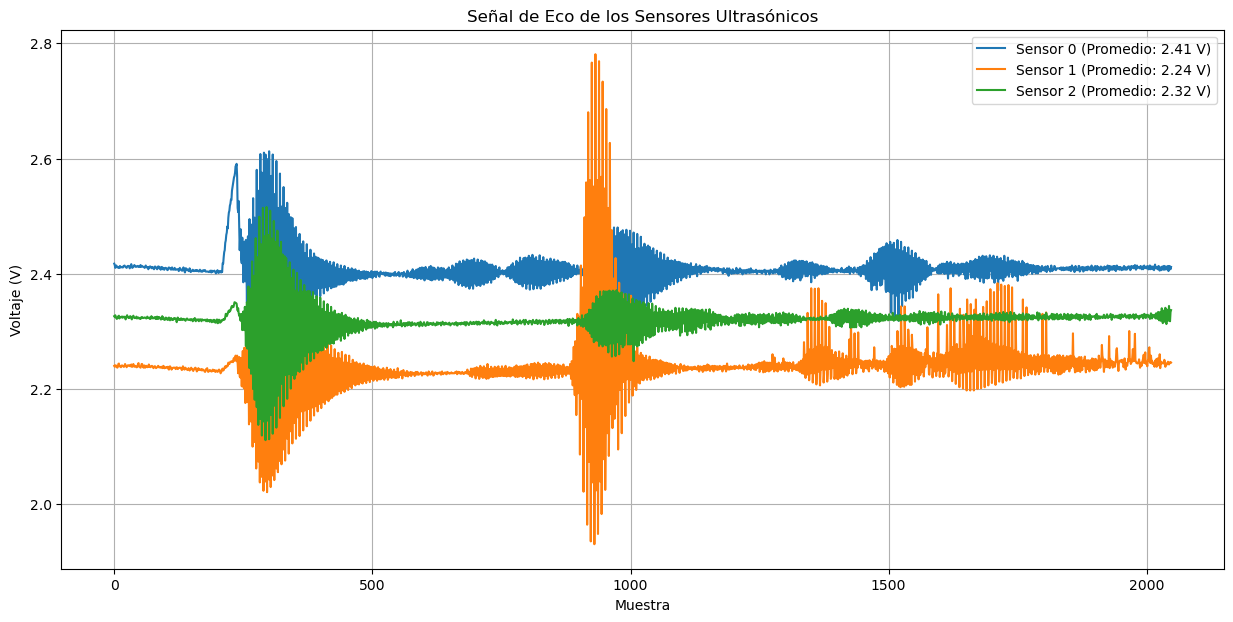

In [87]:
df = pd.read_csv('captured_data/multisensor_data/sample_2025-09-24_20:01:35.csv', header=None, dtype={'Voltages': str}) #read csv file
df = df.replace('\r\n', '', regex = True).drop(0)

plt.figure(figsize=(15, 7))

for j in range(df.shape[0]):
    # Graficamos ignorando los primeros 100 puntos, como en tu código original
    # Usamos np.nanmean() para calcular el promedio ignorando posibles datos faltantes (NaN)
    sensor_data = df.to_numpy().astype(float)[j]
    plt.plot(sensor_data, label=f'Sensor {j} (Promedio: {np.nanmean(sensor_data):.2f} V)')

plt.title("Señal de Eco de los Sensores Ultrasónicos")
plt.xlabel("Muestra")
plt.ylabel("Voltaje (V)")
plt.grid(True)
plt.legend()
plt.show()

In [85]:
def output_dimention_pulses(sample, threshold):
    """
    Description: Function to return the sample number for a detected initial pulse and for the captured echo/es
    Input: sample: Array with all the raw data
            threshold: Threshold value used for the promincence criteria
    Output: output_space
    """
    initial_sample_freq = 140000  # ADC space
    final_sample_freq = 6800  # ML algorithm space
    default_detection_threshold = 0.1
    
    transformation_ratio = final_sample_freq / initial_sample_freq

    if threshold > 0.001:
        prominence = threshold
    else:
        prominence = default_detection_threshold

    signal = sample
    # Obtener la envolvente de la señal usando la Transformada de Hilbert
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    baseline = np.median(envelope)
    envelope_zero_centered = envelope - baseline

    # --- 3. Detección de Picos en la Envolvente ---
    
    # Encuentra picos que tengan una altura mínima de 0.1 por encima del nivel base y
    # que estén separados por al menos 150 muestras.
    peaks, properties = find_peaks(envelope_zero_centered, prominence=prominence, distance=150)

    if peaks[0] < 400:
        initial_pulse = peaks[0]
        peaks_clean = peaks[~(peaks < 500)]
    else:
        initial_pulse = 0
        
    output_space = [int((echo - initial_pulse)*transformation_ratio) for echo in peaks_clean]

        
    return(output_space, peaks)

In [88]:
output_dimention_pulses(df.to_numpy().astype(float)[0], threshold = 0.1)

([32, 59], array([ 300,  975, 1517]))

Picos detectados en las muestras: [ 300  975 1517]
Picos detectados en las muestras: [ 300  975 1517]
Prominencia de los picos detectados: [0.43232125 0.17455771 0.13860239]
[0, 32, 59]


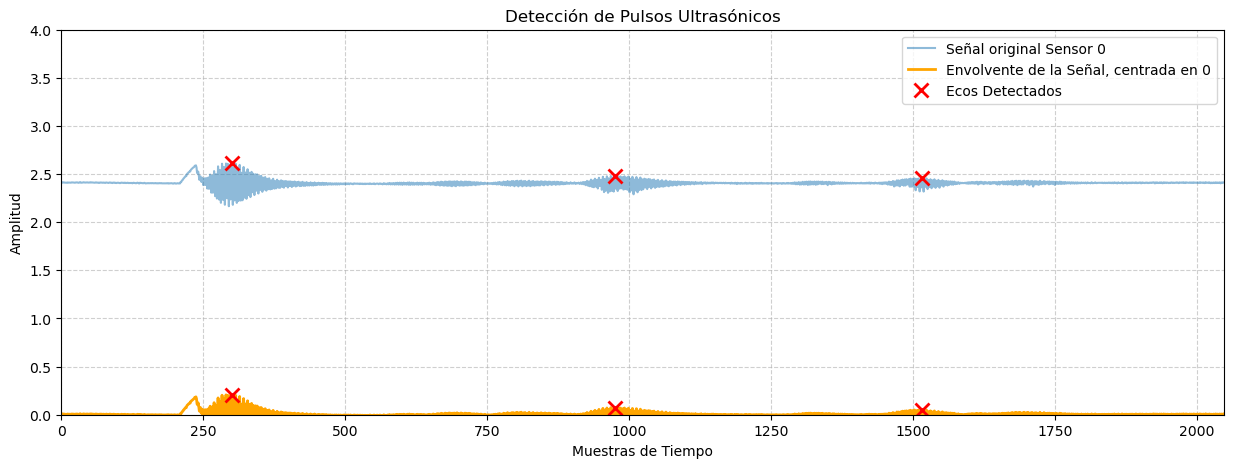

Picos detectados en las muestras: [ 291  932 1350 1524 1711]
Picos detectados en las muestras: [ 291  932 1350 1524 1711]
Prominencia de los picos detectados: [0.41679625 0.82260683 0.17740438 0.13903658 0.1718037 ]
[0, 31, 51, 59, 68]


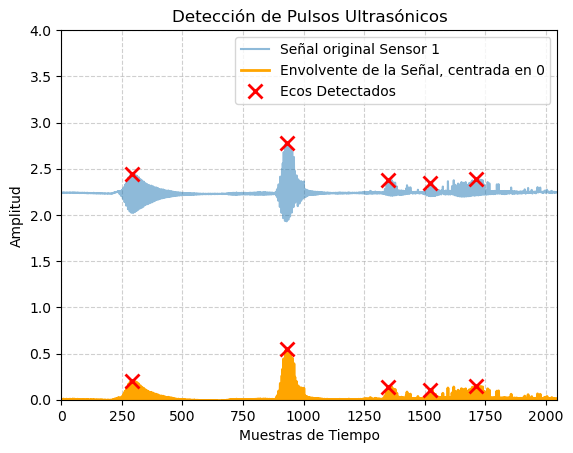

Picos detectados en las muestras: [295 973]
Picos detectados en las muestras: [295 973]
Prominencia de los picos detectados: [0.40269651 0.12312983]
[0, 32]


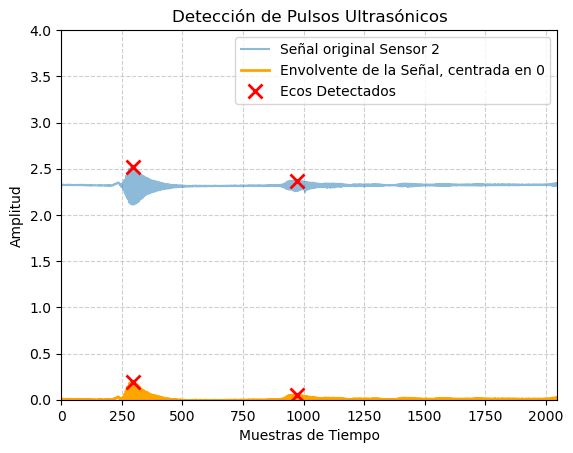

In [15]:

plt.figure(figsize=(15, 5))
initial_sample_freq = 140000  # ADC space
final_sample_freq = 6800  # ML algorithm space

transformation_ratio = final_sample_freq / initial_sample_freq
# --- 2. Limpieza y Procesamiento de la Señal ---
for j in range(df.shape[0]):
    # (Opcional pero recomendado) Aplicar un filtro para suavizar el ruido
    # window_length debe ser impar y polyorder menor que window_length.
    # Ajusta estos valores según tu nivel de ruido.
    signal = df.to_numpy().astype(float)[j]
    smoothed_signal = signal#savgol_filter(signal, window_length=3, polyorder=1)
    
    # Obtener la envolvente de la señal usando la Transformada de Hilbert
    analytic_signal = hilbert(smoothed_signal)
    envelope = np.abs(analytic_signal)
    
    baseline = np.median(envelope)
    envelope_zero_centered = envelope - baseline
    
    # --- 3. Detección de Picos en la Envolvente ---
    
    # Encuentra picos que tengan una altura mínima de 0.2 por encima del nivel base y
    # que estén separados por al menos 150 muestras.
    # ¡AJUSTA ESTOS VALORES! Son los más importantes.
    peaks, properties = find_peaks(envelope_zero_centered, prominence=0.1, distance=150)
    
    # --- 4. Visualización de Resultados ---

    # Gráfica de la señal original y la envolvente
    plt.plot(signal, label=f'Señal original Sensor {j}', alpha=0.5)
    plt.plot(envelope_zero_centered, label='Envolvente de la Señal, centrada en 0', color='orange', linewidth=2)
    # Marcar los picos detectados
    plt.plot(peaks, envelope[peaks], "x", markersize=10, markeredgewidth=2, color='red', label='Ecos Detectados')
    plt.plot(peaks, envelope_zero_centered[peaks], "x", markersize=10, markeredgewidth=2, color='red')
    
    # Imprimir la ubicación de los picos detectados
    print(f"Picos detectados en las muestras: {peaks}")
    # El eco principal es probablemente el que tiene la mayor amplitud
    print(f"Picos detectados en las muestras: {peaks}")
    print(f"Prominencia de los picos detectados: {properties['prominences']}")

    output_space = [int((echo - peaks[0])*transformation_ratio) for echo in peaks]
    
    print(output_space)
    
    plt.title("Detección de Pulsos Ultrasónicos")
    plt.xlabel("Muestras de Tiempo")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim([0, 4])
    plt.xlim([0,2048])
    plt.show()  

### Functions

In [16]:
def echo_distance(p2, p1):
    """
    Description: Function to return the distance between 2 points, taking into account the air speed and sample frequency of the device
    Input: p1: First point
            p2: Second point
    Output: Distance between p1 and p2
    """
    air_speed = 343   # Air speed in m/s
    sample_freq = 140000   # Sample frequency of the device, in Hz
    
    threshold_values = p2-p1  # Amount of samples between the points
    distance = (1/sample_freq)*threshold_values*air_speed/2  # Convert the samples to distance in [m]
    
    return(distance)

In [17]:
def echo_center_point(sample, threshold):
    """
    Description: Function to return the sample number for a detected initial pulse and for the captured echo/es
    Input: sample: Array with all the raw data
            threshold: Value that the mean-criteria needs to meet to consider the sample as a pulse
    Output: echo_center: Sample number/numbers related to the detected echo/echoes
            pulse_center: Sample number related to the detected initial pulse
    """
    
    pulse_window = 7 # Number of samples to compute
    
    echo_values = [] # Sample indexes that meet the threshold (for the received echoes)
    echo_center = [] # Sample indexes for echoes - preprocessed

    pulse_values = [] # Sample indexes that meet the threshold (for the initial pulse)
    pulse_mean_values = [] # Mean values for the computed sample window
    
    
    for i in range(len(sample)):       
        sample_window = sample[i:i+pulse_window]    # Samples within desired window
        window_mean = sum(sample_window)/len(sample_window)  # Window mean value
        if window_mean > threshold: 
            if i > 500:                # index 500 represents the minimum distance a echo pulse could be find
                echo_values.append(i)   # Save the sample index if the sample mean meets the threshold and the index is bigger than 500.
            else:
                pulse_values.append(i)  # For idx smaller than 500 a initial pulse should be existing
                pulse_mean_values.append(window_mean) # Save the sample mean values
                
                
    pulse_idx = pulse_mean_values.index(max(pulse_mean_values)) # Index for the maximum value reached by the pulse
    pulse_center = pulse_values[pulse_idx] # Sample index for the initial pulse center (triggered by the sensor)
    
    pulse_width = 80 #int(len(pulse_values)*0.4)  # Define the maximum width for the pulse
    
    for i in range(0, round(len(echo_values)/pulse_width)):
        temp_values = echo_values[pulse_width*(i):pulse_width*(i+1)]  # Echoes values within the pulse width
        temp_center = sum(temp_values)/len(temp_values)  # Compute the pulse center as the mean within the pulse width
        echo_center.append(int(temp_center))  # Save echoes center
        
    return(echo_center, pulse_center)

### Data cleaning and transformation

- Derivate and noise reduction
    - Derivate the initial raw data. The new ground value will be 0
    - Take absolute value after de derivate to only use positive values. (Usefull in next steps to calculate more precise mean metric)
    - Get rid all the values below certain threshold, to eliminate all the remaining noise after the derivate

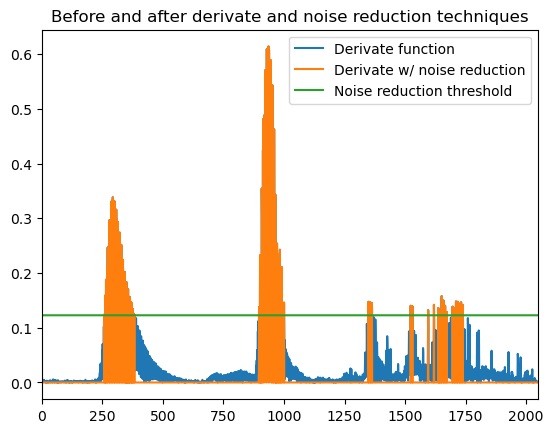

In [50]:
### Select a sample to analize
init_val = 0
n_samples = 1
x = df.to_numpy().astype(float)[1]
y = np.arange(0, len(x))
sample = x[init_val:init_val+(n_samples*2048)]

## Derivate

dx = 1 # Define derivate step
dy = np.abs(diff(sample)/dx) # Derivate the raw data and take absolute value

plt.plot(np.arange(0, len(dy)), dy, label = 'Derivate function')  # Plot the derivate function

### Noise reduction

limit = max(dy)  # Calculate max value
threshold = 0.2  # Set threshold value
dy = [0 if (val < threshold*limit) else val for val in dy]  # All values below (threshold*limit) will be turned into 0 

plt.plot(np.arange(0, len(dy)), dy, label = "Derivate w/ noise reduction")
plt.plot(np.arange(0, len(dy)), [threshold*limit for i in range(len(dy))], label = "Noise reduction threshold")

### Plot results

plt.title('Before and after derivate and noise reduction techniques')
plt.xlim([0,2048])
plt.legend(loc = 'upper right')
plt.show()

### Echo Signature decoding

Goals:
- Detect the initial pulse triggered by the sensor
- Detect the captured echo/echoes

Method:
- Mean-criteria: 
    - By moving a window over the longitude of the sample and computing the mean value within the window.
    - If the mean meet a certain threshold value, the sample index is saved
    - After the windowing, a set of width and separation rules are computed to only keep the important index values

Pulse center point:  299
Echo center point:  []


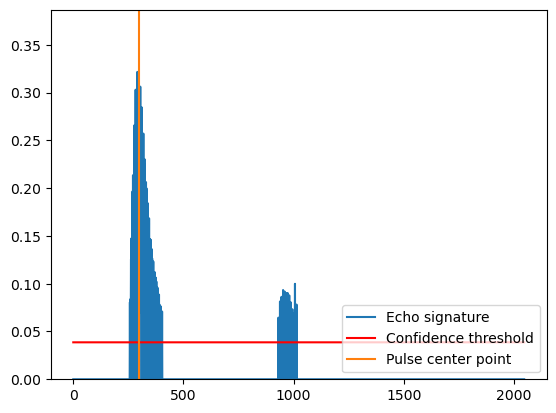

In [49]:
### Define sample to analize

sample = dy
ax_y = np.arange(0, len(sample))
plt.plot(ax_y, sample, label = "Echo signature")  #Plot sample data

### Define a confidence threshold to compute the mean-criteria to detect the pulses

threshold = 0.12*max(sample)
confidence_threshold = [threshold for i in range(len(sample))]
plt.plot(ax_y,confidence_threshold, color = 'red', label = 'Confidence threshold')

### Calculate the echo/echoes center

echo_plot_y = [i for i in range(2)]
center_point = echo_center_point(sample, threshold)[0]

for i in range(len(center_point)): 
    echo_plot_x = [center_point[i] for j in range(len(echo_plot_y))]
    plt.plot(echo_plot_x, echo_plot_y, label = 'Echo center point')

### Calculate the pulse center

center_point_pulse = int(echo_center_point(sample, threshold)[1])
echo_plot_x = [center_point_pulse for i in range(len(echo_plot_y))]
plt.plot(echo_plot_x, echo_plot_y, label = 'Pulse center point')

### Plot and print results

print('Pulse center point: ', center_point_pulse)
print('Echo center point: ', center_point)

plt.ylim([0, 1.2*max(sample)])
plt.legend(loc = "lower right")
plt.show()

i = 0
for echo_point in center_point:
    print('Echo distance', i, '->' , echo_distance(echo_point, center_point_pulse), '[m]')
    i += 1

### Signature transformation

- The initial space is generated by a sample frequency of 140[KHz]
- The space used by the ML algorithm is of size (,81)
    - Meaning sample frequency of 6800 [Hz]
    - Explanation:
        - For 2[m] range, the maximum round trip is 4[m]
        - Sound speed on air is 343[m/s], so for the 4[m] trip the wave will take 12[ms] to complete the trip
        - With a sample frequency of 6800[Hz], during the whole trip 81 samples will be taken
        
 We need to transform the original space captured by the sensor to the space compatible with the ML inference algorithm

In [89]:
initial_sample_freq = 140000  # ADC space
final_sample_freq = 6800  # ML algorithm space

transformation_ratio = final_sample_freq / initial_sample_freq

output_space = [int((echo - center_point_pulse)*transformation_ratio) for echo in center_point]

print(output_space)

[]


### Transformation tests

In [ ]:
##KALMAN FILTER TEST
print(sample)
print(kalman_filter(sample))

ax_x = sample
ax_y = np.arange(0, len(sample))

plt.subplot(2,1,1)

plt.plot(ax_y, ax_x, label = "Without filtering")
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")

plt.legend()

plt.subplot(2,1,2)
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")
plt.legend()
plt.show()

In [ ]:
init_val = 2048
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]

kalman = kalman_filter(sample)

plt.plot(ax_y, kalman, label = "Kalman")

sample = (np.exp(sample - sample.mean())-1)*30

ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
#plt.plot(ax_y, ax_x, label = "Without filtering")

#Mean filter
i = 0
for n_sample in sample:
    
    if i == 0:
        sample[i] = (sample[i] + sample[i+1] )/2
    elif i == len(sample)-1:
        sample[i] = (sample[i] + sample[i-1])/2
    else:
        sample[i] = (sample[i-1] + sample[i] + sample [i+1] )/ 3
    
    i+=1

ax_x = sample*2
#plt.plot(ax_y, ax_x, label = "With filtering")

plt.legend(loc = "lower right")
plt.show()